##### This script will associate spoken phrases with their corresponding translation, using Dynamic Time Warping (DTW) algorithm on MFCC of audio recordings. This example will rely on 10 phrases I recorded myself saying 10 times each.

## 1) Load Packages

In [133]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# import matplotlib.pylab as plt
from skimage import data, img_as_float
from skimage import exposure
import sklearn
import random
import itertools
import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

## 2) Load Data and Compute MFCCs

In [155]:
prompt_master = pd.read_csv('../data/recorded/recorded_prompts.txt', sep="|", 
                      header=None, names=['prompt_id','prompt'])

prompt_master.head()
num_classes = len(prompt_master['prompt']) 
print('Unique prompts:', num_classes)

Unique prompts: 10


In [156]:
# LOAD 1 RECORD IN TRAINING AND 9 RECORDS IN TEST FOR EACH PROMPT
mfcc = []
prompts = []
prompt_text = []
train = []

for p in range(1,11):
    print(prompt_master['prompt'][p-1])
    for i in range(1,11):
        aud_loc = '../data/recorded/' + str(p) + '_' + str(i) + '.wav'
        #print(aud_loc)
                
        data, rate = librosa.load(aud_loc)
        
#         # Trim leading and trailing silence
# 
#         len_pre = librosa.get_duration(data) * 100.000
#         data, index = librosa.effects.trim(data, frame_length=40, hop_length=10)
#         print('Amount trim: ', len_pre - (librosa.get_duration(data) * 100.000))
        
        #Add white noise
        
        wn = np.random.randn(len(data))
        data = data + 0.005*wn
        
        mfcc.append(librosa.feature.mfcc(data, rate))
        
        prompts.append(p-1)
        prompt_text.append(prompt_master['prompt'][p-1])
        
        train.append(1 if i <= 1 else -1)

what day is today
how are you
i am hungry
i need to go to the bathroom
i am tired
i am happy
i am sad
the quick brown fox jumped over the lazy dog
i want to go for a walk
please turn on the tv


In [157]:
# Remove first MFCC because it does not convey information relevant to the overall shape of the spectrum. It only conveys a constant offset
# I also removed first and last. Didn't impact results.
# Source: https://musicinformationretrieval.com/mfcc.html
for i,x in enumerate(mfcc): 
    
    #mfcc[i] = mfcc[i][1:-1]
    
    # Also can scale features - looks like this helps
    mfcc[i] = sklearn.preprocessing.scale(mfcc[i], axis=1)
    
print(mfcc[0].shape)    

(20, 78)


{0: 'what day is today', 1: 'how are you', 2: 'i am hungry', 3: 'i need to go to the bathroom', 4: 'i am tired', 5: 'i am happy', 6: 'i am sad', 7: 'the quick brown fox jumped over the lazy dog', 8: 'i want to go for a walk', 9: 'please turn on the tv'}


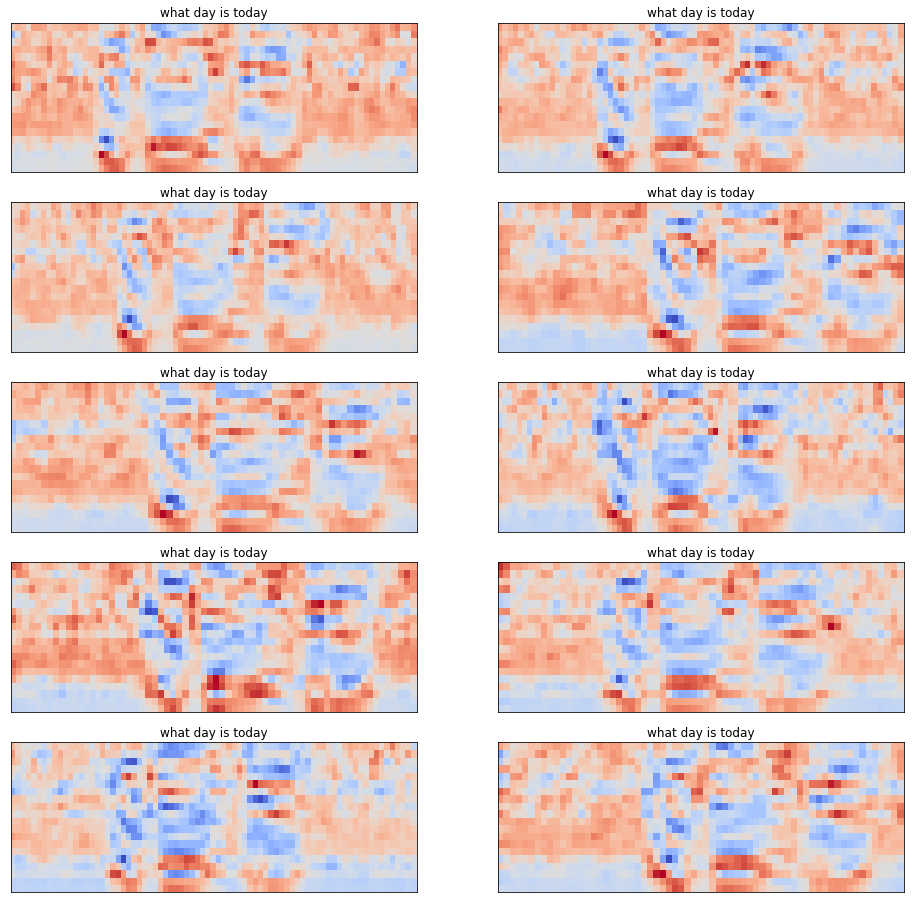

In [158]:
cat = dict(zip(prompts, prompt_text))  # Dictionary to look up prompt text from prompt code
num_examples = 10

fig = plt.figure(figsize=(16, 16))

for i in range(num_examples):
    plt.subplot(5,2,i+1)
    librosa.display.specshow(mfcc[i])
    plt.title(cat.get(prompts[i]))
    
print(cat)

## 3) Compare using DTW

In [159]:
from scipy.spatial.distance import euclidean
from numpy.linalg import norm
from fastdtw import fastdtw

In [160]:
x_train = [mfcc[i] for i,x in enumerate(train) if x==1]
y_train = [prompts[i] for i,x in enumerate(train) if x==1]
x_test = [mfcc[i] for i,x in enumerate(train) if x==-1]
y_test = [prompts[i] for i,x in enumerate(train) if x==-1]
print('# train: ', len(y_train))
print('# test: ', len(y_test))

# train:  10
# test:  90


In [161]:
# Create 90 x 10 matrix - where each row represents the distance calculated by the algorithm
dtw_dist = []
for i,x in enumerate(x_test):
    dist = []
    for i2,x2 in enumerate(x_train):
        distance, path = fastdtw(x.T, x2.T, dist=lambda x, y: norm(x - y, ord=1))
        #distance, path = fastdtw(x.T, x2.T, dist=euclidean)
        dist.append(distance)
    dtw_dist.append(dist)

In [162]:
# Show the distances

pd.DataFrame(dtw_dist, np.repeat(prompt_master['prompt'],9), prompt_master['prompt'])

prompt,what day is today,how are you,i am hungry,i need to go to the bathroom,i am tired,i am happy,i am sad,the quick brown fox jumped over the lazy dog,i want to go for a walk,please turn on the tv
prompt,,,,,,,,,,
what day is today,804.209343,1409.922268,1289.669187,1322.478445,1200.122763,1370.811720,1299.011988,2245.285657,1315.859566,1498.978225
what day is today,883.879845,1487.804391,1352.198692,1382.057873,1428.804290,1459.838296,1231.683046,2313.190101,1387.832081,1527.908368
what day is today,1533.024140,1039.054937,1308.499283,1345.598014,1278.563996,1267.038247,1161.406907,2231.476486,1356.044463,1536.671404
what day is today,1534.338150,1075.413990,1217.766139,1231.003272,1285.956859,1185.135539,996.299134,2349.472734,1279.037431,1508.670786
what day is today,1167.591393,1218.538158,1381.504956,1358.979502,1526.461552,1438.278646,1214.472582,2510.873982,1424.622493,1482.983594
what day is today,997.022378,1085.773356,1211.899180,1206.217759,1068.176239,1126.090072,1118.445501,2309.892345,1241.516506,1512.869392
what day is today,806.420854,1260.668713,1163.475563,1233.720497,1168.798870,1185.653155,1085.506485,2269.953429,1224.249765,1424.478571
what day is today,872.093793,1425.301011,1308.580983,1458.080731,1241.169277,1371.761563,1245.999142,2369.890261,1415.412346,1500.336091
what day is today,1493.891517,1041.731237,1224.647659,1208.663140,1257.577865,1202.636756,1197.939136,2343.676721,1332.208121,1468.013137


In [163]:
# ax = sns.heatmap(dtw_dist, linewidth=0.5)
# plt.show()

In [164]:
fmt = '{:<50}{}'
num_correct = 0

print(fmt.format('Correct', 'Predicted'))
print('----------------------------------------------------------------------')

for i,x in enumerate(dtw_dist):
    print(fmt.format(cat.get(y_test[i]), cat.get(x.index(min(x)))))
    if y_test[i] == x.index(min(x)): num_correct += 1
        
print('----------------------------------------------------------------------')    
print('% Correct:', num_correct / 90.0 * 100)

Correct                                           Predicted
----------------------------------------------------------------------
what day is today                                 what day is today
what day is today                                 what day is today
what day is today                                 how are you
what day is today                                 i am sad
what day is today                                 what day is today
what day is today                                 what day is today
what day is today                                 what day is today
what day is today                                 what day is today
what day is today                                 how are you
how are you                                       how are you
how are you                                       how are you
how are you                                       how are you
how are you                                       how are you
how are you                   

##### Results (1 train and 9 test records): 

1) 81% accuracy using dist = norm(x-y)

2) 71% accuracy using dist = euclidean

3) 83% accuracy using dist = norm(x-y) + white noise

4) 78% accuracy using dist = euclidean + white noise

5) 81% accuracy using dist = norm(x-y) + white noise + noise trim

6) 86% accuracy using dist = norm(x-y) + scaled features

6) 84% accuracy using dist = norm(x-y) + white noise + scaled features

##### Ideas

1) Run a DTW for each of the 20 MFCCs and vote best of 20